In [2]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
from math import sqrt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values, state_to_return, pauli_to_int, int_to_pauli,\
    basis_T_to_pauli, reversed_str_bases_to_init_state, kernel_qaoa_Preserved, get_optimizer, optimizer_names

import time

cudaq.set_target("nvidia")

np.random.seed(42)

!! warning: Representing Pauli words using INTEGER !!

In [3]:
print(4**30 // 10**18)

1


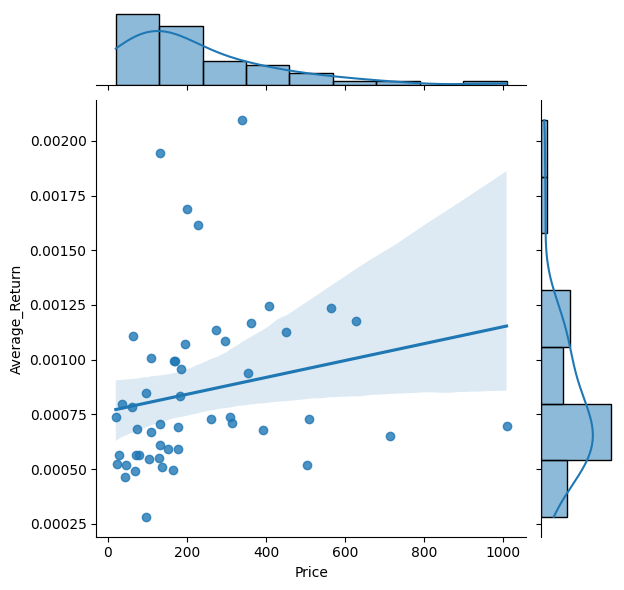

20.049999237060547 1008.5
0.0002817427940077 0.0020945858866767


In [6]:
import seaborn as sns
from copulas.multivariate import GaussianMultivariate
import joblib
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

data = data_ret_p.drop("Ticker", axis=1)
sns.jointplot(data=data, x='Price', y='Average_Return', kind='reg')
plt.show()

print(data["Price"].min(), data["Price"].max())
print(data["Average_Return"].min(), data["Average_Return"].max())

In [4]:
# X = data[['Price', 'Average_Return']]
# GM = GaussianMultivariate()
# GM.fit(X)
# joblib.dump(GM, './models/gaussian_copula.pkl')

0.00047935012980475784 0.0020720678257544305


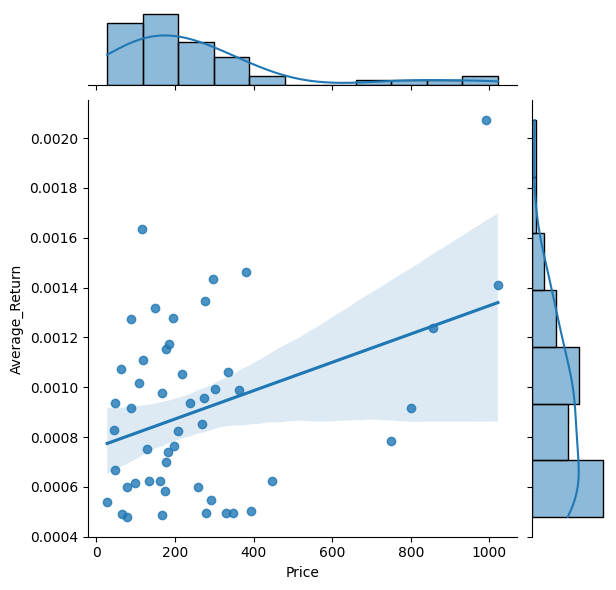

In [5]:
GM_loaded = joblib.load('./models/gaussian_copula.pkl')
samples = GM_loaded.sample(50)
print(samples["Average_Return"].min(), samples["Average_Return"].max())
sns.jointplot(data=samples, x='Price', y='Average_Return', kind='reg')
plt.show()

# HAMILTONIAN BY CUDAQ

### by random values

In [ ]:
B = 100
ret = np.array([1.0, 1.25, 1.5])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 0 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)
print("n_max:", n_max)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)

[[0.83482201 0.55972298 0.63865599]
 [0.55972298 1.88581941 1.02622189]
 [0.63865599 1.02622189 0.7272592 ]]
n_max: [1 1 1]
ret_bb: [1.   1.25 1.5 ]
n_qubit: 3


In [7]:
print("Hamiltonian:", H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-0.5+0i) * I0 + (0.5+0i) * Z0 + (0+0i) + (-0.625+0i) * I1 + (0.625+0i) * Z1 + (-0.75+0i) * I2 + (0.75+0i) * Z2
[0, 1, 2]
[0.5, 0.625, 0.75]

[]
[]
[]


### by stock values

In [8]:
data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

nn = 3
# B = 1500
B = 270
lamb = 0 # Budget Penalty
q = 0 # Volatility Weight

data_cov = data_cov.drop("Ticker", axis=1).iloc[:nn, :nn]
print(data_cov)
data_ret_p = data_ret_p.iloc[:nn]
# data_ret_p.loc[0, "Average_Return"] = 0.002070
# data_ret_p.loc[1, "Average_Return"] = 0.000050
# data_ret_p.loc[2, "Average_Return"] = 0.002070
print(data_ret_p)
stock_names = data_ret_p["Ticker"].tolist()
data_ret_p = data_ret_p.drop("Ticker", axis=1)

data_cov = data_cov.to_numpy()
data_ret_p = data_ret_p.to_numpy()

data_ret = data_ret_p[:, 0]
data_p = data_ret_p[:, 1]

print(data_cov.shape)
print(data_ret.round(5))
print(data_p.round(2))
print(stock_names)

       AAPL      ABBV       ABT
0  0.000772  0.000078  0.000100
1  0.000078  0.000279  0.000103
2  0.000100  0.000103  0.000256
  Ticker  Average_Return       Price
0   AAPL        0.001070  195.270004
1   ABBV        0.000832  183.259995
2    ABT        0.000706  131.300003
(3, 3)
[0.00107 0.00083 0.00071]
[195.27 183.26 131.3 ]
['AAPL', 'ABBV', 'ABT']


In [9]:
P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, data_p, data_ret, data_cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb).canonicalize() * 500

n_max: [1 1 2]
ret_bb: [0.00077414 0.00056486 0.00034333 0.00068666]
n_qubit: 4


In [10]:
print("Hamiltonian:", H)
# print("H canonicalized:", H.canonicalize())
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-0.592249+0i) + (0.193536+0i) * Z0 + (0.141215+0i) * Z1 + (0.0858325+0i) * Z2 + (0.171665+0i) * Z3
[0, 1, 2, 3]
[0.19353621438596744, 0.1412153785790853, 0.08583247190085473, 0.17166494380170946]

[]
[]
[]


In [11]:
print(list(map(int, "0010")))

[0, 0, 1, 0]


In [12]:
# def state_to_return(s, B, C, d_ret, d_p):
#     l = np.array(list(map(int, s)))
#     P = d_p @ C
#     ret_C = (d_ret * d_p) @ C
#     ss = l @ ret_C
#     bud = l @ P
#     return ss, bud <= B

ex_ret, in_budget = state_to_return("0001", B, C, data_ret, data_p)
print(ex_ret, in_budget)

0.18539813930584623 True


# CUDA QAOA

In [13]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [14]:
print(H)
print(n_qubit)

(-0.592249+0i) + (0.193536+0i) * Z0 + (0.141215+0i) * Z1 + (0.0858325+0i) * Z2 + (0.171665+0i) * Z3
4


In [15]:
# bases = ["0001", "0010"]
# T = np.array([[0, 1], [1, 0]])
# mixer_s, mixer_c, A_all = basis_T_to_pauli(bases, T, len(bases[0]))
# print(f"{mixer_s}\n{mixer_c}")

# print(A_all.to_matrix())

# # AA_all = A_all.copy()
# AA_all = 0.25 * spin.x(0) * spin.x(2) + 0.25 * spin.x(0) * spin.z(1) * spin.x(2) \
#        + 0.25 * spin.y(0) * spin.y(2) + 0.25 * spin.y(0) * spin.z(1) * spin.y(2)
# print(AA_all.to_matrix())

In [16]:
# bases = ["100", "010", "001"]
# T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

bases = ["1000", "0100", "0001"]
# bases = ["100000", "010000", "000100"]
T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
# T = np.array([[0, 0, 1], [0, 0, 0], [0, 0, 0]])
# T = np.array(
#     [[0, 1, 0, 1],
#      [1, 0, 1, 0],
#      [0, 1, 0, 1],
#      [1, 0, 1, 0]]
# )

mixer_s, mixer_c = basis_T_to_pauli(bases, T, n_qubit)

# ss_i = [int_to_pauli(s, n_qubit) for s in mixer_s]
# print(f"{mixer_s}\n{ss_i}\n{mixer_c}")

print(f"{mixer_s}\n{mixer_c}")
init_bases = reversed_str_bases_to_init_state(bases, n_qubit)
print("init_bases:", abs(init_bases))

['XXII', 'XXIZ', 'XXZI', 'XXZZ', 'YYII', 'YYIZ', 'YYZI', 'YYZZ', 'XIIX', 'XIZX', 'XZIX', 'XZZX', 'YIIY', 'YIZY', 'YZIY', 'YZZY', 'IXIX', 'IXZX', 'ZXIX', 'ZXZX', 'IYIY', 'IYZY', 'ZYIY', 'ZYZY']
[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
init_bases: [0.         0.57735026 0.57735026 0.         0.         0.
 0.         0.         0.57735026 0.         0.         0.
 0.         0.         0.         0.        ]


In [17]:
print(cudaq.draw(kernel_qaoa_Preserved, [0.5]*4, n_qubit, 1, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases))

     ╭────────────╮ ╭───╮                        ╭───╮╭───╮          »
q0 : ┤ rz(0.1935) ├─┤ h ├──●──────────────────●──┤ h ├┤ h ├──●───────»
     ├────────────┤ ├───┤╭─┴─╮╭────────────╮╭─┴─╮├───┤├───┤╭─┴─╮     »
q1 : ┤ rz(0.1412) ├─┤ h ├┤ x ├┤ rz(-0.125) ├┤ x ├┤ h ├┤ h ├┤ x ├──●──»
     ├────────────┴╮╰───╯╰───╯╰────────────╯╰───╯╰───╯╰───╯╰───╯  │  »
q2 : ┤ rz(0.08583) ├──────────────────────────────────────────────┼──»
     ├────────────┬╯                                            ╭─┴─╮»
q3 : ┤ rz(0.1717) ├─────────────────────────────────────────────┤ x ├»
     ╰────────────╯                                             ╰───╯»

################################################################################

                        ╭───╮╭───╮                                  ╭───╮╭───╮»
─────────────────────●──┤ h ├┤ h ├──●────────────────────────────●──┤ h ├┤ h ├»
                   ╭─┴─╮├───┤├───┤╭─┴─╮                        ╭─┴─╮├───┤├───┤»
────────────────●──┤ x ├┤ h ├┤ h ├┤ x 

# Ansatz Architecture

In [18]:
idx = 3
layer_count = 5

parameter_count = layer_count * 2
optimizer, optimizer_name, FIND_GRAD = get_optimizer(idx)

optimizer.max_iterations = 1000


optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases)

Initial parameters =  [0.3705367812928655, 0.36320525611565224, -0.19494972898149013, -0.0021610184187193515, -0.1563898097625048, -0.16898588055343988, -0.3637281409931357, 0.0860516266816756, 0.002104099923646907, -0.3522677650129884]


In [19]:
print(optimizer.episodes)

None


# Optimize

In [20]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_Preserved, H, parameters, *ansatz_fixed_param).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [21]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

if not os.path.exists("./output_PO_mixer"):
    os.makedirs("./output_PO_mixer")
np.save(f"./output_PO_mixer/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = -0.38152819299451957
optimal_parameters = [0.04531129988702345, 0.013504755321200438, -0.3384591513296177, -0.36064455875604157, -0.5474430630575421, -0.04548050202110984, -0.7943620056219682, 0.5428693557281368, 0.4243206620194912, -0.7532368227507288]
Time taken =  0.787808895111084


In [22]:
shots_count = int(1e6)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_Preserved, optimal_parameters, *ansatz_fixed_param, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 1000000 times...
Finding the best solution...
1000 904687 0.904687
|q0>|q1>|q2>...


In [23]:
state = cudaq.get_state(kernel_qaoa_Preserved, optimal_parameters, *ansatz_fixed_param)
print(state)

rows = []
col = ["State", "Probability", "Return", "In_Budget"]
ret_sum = 0
state_best, return_best = "", 0
state_high, return_high = result.most_probable(), 0
for i in range(len(state)):
    bb = bin(i)[2:].zfill(n_qubit)
    ret, in_bud = state_to_return(bb, B, C, data_ret, data_p)
    if in_bud and ret > return_best:
        state_best, return_best = bb, ret
    if state_high == bb:
        return_high = ret
    prob = abs(state[i])**2
    # print(bb, "\t", round(abs(state[i])**2, 4), "\t", round(ret, 4))
    al = np.array([bb, round(abs(state[i])**2, 4), round(ret, 4), in_bud])
    rows.append(al)
    ret_sum += ret * prob
    # print(al)

df = pd.DataFrame(rows, columns=col)
print(df)
print("Expected Return:", round(ret_sum, 4))

colorr = ["blue" if in_bud == "True" else "red" for in_bud in df["In_Budget"]]
ex_ret = df["Return"].to_numpy()
# print(len(state))

print("Best state:", state_best, "Return:", return_best)
print("Most probable state:", state_high, "Return:", return_high)

SV: [(0,0), (0.883396,-0.352958), (0.126177,0.0753395), (0,0), (0,0), (0,0), (0,0), (0,0), (-0.211546,-0.169363), (0,0), (0,0), (1.92693e-09,2.24271e-08), (0,0), (0,0), (0,0), (0,0)]

   State Probability  Return In_Budget
0   0000         0.0     0.0      True
1   0001      0.0734  0.1854      True
2   0010         0.0  0.0927      True
3   0011         0.0  0.2781     False
4   0100      0.0216  0.1525      True
5   0101         0.0  0.3379     False
6   0110         0.0  0.2452     False
7   0111         0.0  0.4306     False
8   1000       0.905   0.209      True
9   1001         0.0  0.3944     False
10  1010         0.0  0.3017     False
11  1011         0.0  0.4871     False
12  1100         0.0  0.3615     False
13  1101         0.0  0.5469     False
14  1110         0.0  0.4542     False
15  1111         0.0  0.6396     False
Expected Return: 0.2061
Best state: 1000 Return: 0.20901911153684485
Most probable state: 1000 Return: 0.20901911153684485


In [24]:
assert False

AssertionError: 

In [25]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [Text(0, 0, '0000'), Text(1, 0, '0001'), Text(2, 0, '0010'), Text(3, 0, '0011'), Text(4, 0, '0100'), Text(5, 0, '0101'), Text(6, 0, '0110'), Text(7, 0, '0111'), Text(8, 0, '1000'), Text(9, 0, '1001'), Text(10, 0, '1010'), Text(11, 0, '1011'), Text(12, 0, '1100'), Text(13, 0, '1101'), Text(14, 0, '1110'), Text(15, 0, '1111')]


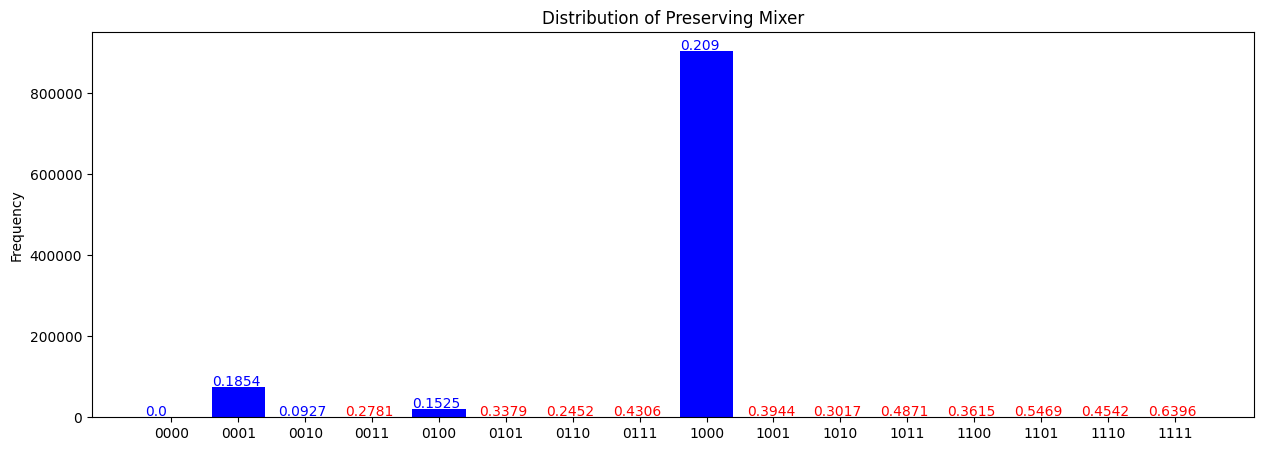

In [26]:
# plt.figure(figsize=(100, 15))
x = np.arange(2**n_qubit)
plt.figure(figsize=(15, 5))

# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final, color=colorr)
# plt.bar(range(int(2**(n_qubit-3)*0.1)), result_final[2**(n_qubit-3)*4:int(2**(n_qubit-3)*4.1)])
plt.ylabel('Frequency')
plt.title('Distribution of Preserving Mixer')
# plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
# plt.xticks(xlocs, xlabs)
plt.xticks(x, [f"{i:0{n_qubit}b}" for i in x])
xlocs, xlabs = plt.xticks()
print(xlocs, xlabs)
for i, s in enumerate(ex_ret):
    plt.text(xlocs[i]-0.4, result_final[i]+shots_count/400, s, color=colorr[i])

plt.show()

Exhaustive Search

x: qubit (100 samples per qubit)
y: approx ratio (best vs real best)

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


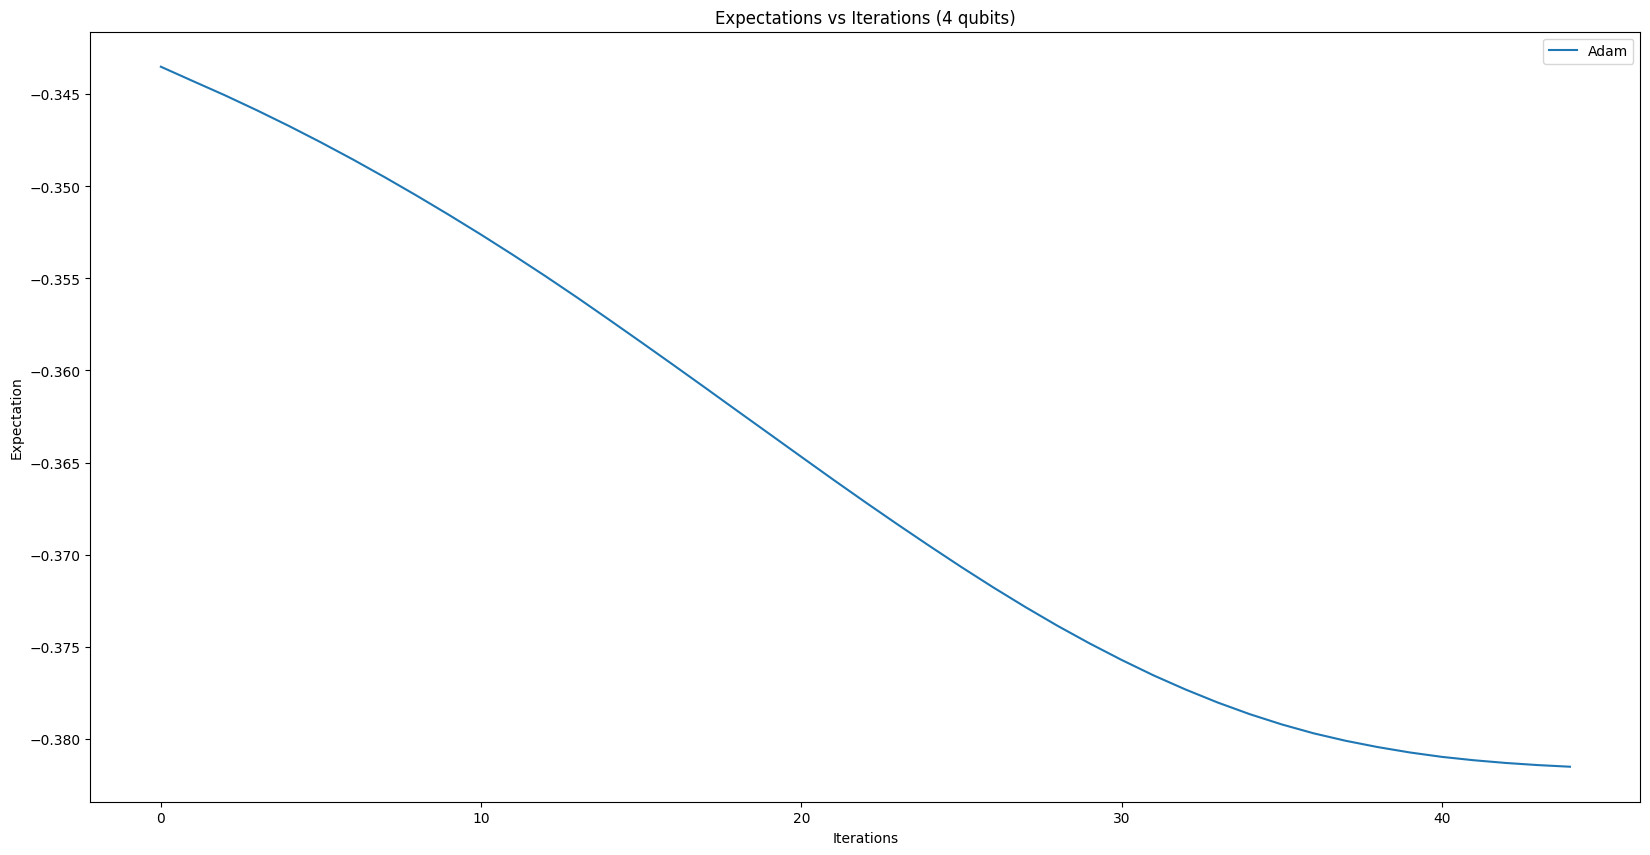

In [27]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()